Importing Packages 

In [29]:
import pandas as pd
from pathlib import Path
import time
import tqdm
from datetime import datetime
import os
from sklearn.model_selection import KFold
import sys
import pytorch_lightning as plit
import pandas as pd
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, roc_curve
from sklearn.metrics import auc as skauc
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import numpy as np
from multiprocessing import Pool
import multiprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from xgboost import XGBClassifier, XGBRegressor
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
import torch
import argparse
import dateutil
import shap
import re

# K-fold validation
n_splits = 5  
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

Loading Prescriptions and Admissions File

In [2]:
#Load Prescriptions CSV File into Pandas Dataframe 
prescriptions_df = pd.read_csv("dataset/PRESCRIPTIONS.csv")
#Load Admissions CSV File into  Dataframe 
admissions_df = pd.read_csv("dataset/ADMISSIONS.csv",low_memory=False)

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Define conversion factors for dosage units
conversion_factors = {
    'mg': 1,
    'mcg': 0.001,
    'g': 1000,
    'pill': 50,
    'tab': 50,
    'gm': 1000,
    'mEq': 74.5,
    'mL': 1,
    'UNIT': 100,
    'mcg/hr': 0.001,
    'mg/hr': 1,
}

# Convert DOSE_UNIT_RX to conversion factors and multiply by DOSE_VAL_RX to get dose in mg
prescriptions_df['DOSE_VAL_RX'] = pd.to_numeric(prescriptions_df['DOSE_VAL_RX'], errors='coerce').fillna(0)
prescriptions_df['dose_mg'] = prescriptions_df['DOSE_VAL_RX'] * prescriptions_df['DOSE_UNIT_RX'].map(conversion_factors).fillna(1)

# Group by unique patient ID and DRUG to count occurrences and sum dosages
grouped_counts = prescriptions_df.groupby(['SUBJECT_ID', 'DRUG']).size().unstack(fill_value=0)
grouped_dosages = prescriptions_df.groupby(['SUBJECT_ID', 'DRUG'])['dose_mg'].sum().unstack(fill_value=0)

# Concatenate the counts and dosage DataFrames, ensuring we keep the SUBJECT_ID as a column
final_df = pd.concat([grouped_counts.add_suffix('_count'), grouped_dosages.add_suffix('_dose')], axis=1)

# Reset the index to convert 'SUBJECT_ID' back to a regular column
final_df.reset_index(inplace=True)

# Add a column for the number of unique drugs taken per patient
final_df['num_unique_drugs'] = (grouped_counts > 0).sum(axis=1)

# Add a column indicating if any drugs were taken by a patient (1 if any drug taken, 0 otherwise)
final_df['any_drug_taken'] = final_df['num_unique_drugs'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
#ADMISSIONS FILE 

admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'],)
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])
admissions_df['DEATHTIME'] = pd.to_datetime(admissions_df['DEATHTIME'],)
    
# New logic to filter patients based on discharge/death time within the timeframe
admit_times = admissions_df['ADMITTIME']
mapping_discharge = dict(zip(admissions_df['SUBJECT_ID'], admissions_df['ADMITTIME']))
discharge_times = admissions_df['DISCHTIME']
death_times = admissions_df['DEATHTIME']

admit_times = admissions_df['ADMITTIME']
discharge_times = admissions_df['DISCHTIME']
death_times = admissions_df['DEATHTIME']

# Make sure 'ADMITTIME' and 'DOB' are in datetime format
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])

#MERGING PRESCRIPTIONS WITH ADMISSIONS FILES 
merged_df = pd.merge(final_df, admissions_df, on='SUBJECT_ID', how='inner')


merged_df['mortality_label'] = 0 
merged_df.loc[merged_df['DISCHTIME'].notnull(), 'mortality_label'] = 0 #Patient who survived 0
duplicate_subject_ids_admissions = admissions_df[admissions_df.duplicated('SUBJECT_ID', keep=False)]

# Check for duplicate subject IDs in final_df
duplicate_subject_ids_final = final_df[final_df.duplicated('SUBJECT_ID', keep=False)]

# Check for duplicate subject IDs in merged_df
duplicate_subject_ids_merged = merged_df[merged_df.duplicated('SUBJECT_ID', keep=False)]

# Print the lengths of the original dataframes and the merged dataframe
print("Length of admissions_df:", len(admissions_df))
print("Length of final_df:", len(final_df))
print("Length of merged_df:", len(merged_df))

# Print the number of duplicate subject IDs in each dataframe
print("Number of duplicate subject IDs in admissions_df:", len(duplicate_subject_ids_admissions))
print("Number of duplicate subject IDs in final_df:", len(duplicate_subject_ids_final))
print("Number of duplicate subject IDs in merged_df:", len(duplicate_subject_ids_merged))

# Optionally, print the duplicate subject IDs for further investigation
print("Duplicate subject IDs in admissions_df:", duplicate_subject_ids_admissions['SUBJECT_ID'].unique())
print("Duplicate subject IDs in final_df:", duplicate_subject_ids_final['SUBJECT_ID'].unique())
print("Duplicate subject IDs in merged_df:", duplicate_subject_ids_merged['SUBJECT_ID'].unique())

merged_df = merged_df[merged_df['SUBJECT_ID'].isin(admissions_df['SUBJECT_ID'])]
merged_df.drop_duplicates(subset='SUBJECT_ID', keep=False, inplace=True)


Length of admissions_df: 58976
Length of final_df: 39363
Length of merged_df: 51366
Number of duplicate subject IDs in admissions_df: 19993
Number of duplicate subject IDs in final_df: 0
Number of duplicate subject IDs in merged_df: 19154
Duplicate subject IDs in admissions_df: [   23    34    36 ... 98744 98759 98761]
Duplicate subject IDs in final_df: []
Duplicate subject IDs in merged_df: [   17    21    23 ... 99897 99923 99982]


In [16]:
def analyze_features(features_scaled, feature_names, y, top_n_features=10, return_top_features=False):
    """
    Analyze features using SHAP values, Linear Regression, and PCA,
    select the top features from each method without duplicates, and visualize the results.

    :param features_scaled: Scaled feature numpy array
    :param feature_names: List of feature names
    :param y: True labels
    :param top_n_features: Number of top features to retain from each method
    """
    # Linear Regression for feature importance
    lr_model = LinearRegression()
    lr_model.fit(features_scaled, y)

    # Principal Component Analysis
    pca = PCA(n_components=len(feature_names))
    pca.fit(features_scaled)
    feature_importance_pca = pca.explained_variance_ratio_
    top_features_pca = np.argsort(feature_importance_pca)[-top_n_features:]

    # Linear Regression
    plt.figure(figsize=(10, 6))
    indices_lr = np.argsort(np.abs(lr_model.coef_))[::-1][:top_n_features]
    plt.title("Top Linear Regression Coefficients")
    plt.barh(range(top_n_features), np.abs(lr_model.coef_)[indices_lr], color='b', align='center')
    plt.yticks(range(top_n_features), [feature_names[i] for i in indices_lr])
    plt.xscale('log')
    plt.gca().invert_yaxis()  # Invert y-axis to have largest values at the top

    # PCA
    plt.figure(figsize=(10, 6))
    plt.title("Top PCA Explained Variance Ratio")
    plt.barh(range(top_n_features), feature_importance_pca[top_features_pca], color='b', align='center')
    plt.yticks(range(top_n_features), [feature_names[i] for i in top_features_pca])
    plt.gca().invert_yaxis()  # Invert y-axis to have largest values at the top

    # Combine and remove duplicates
    combined_feature_indices = np.unique(np.concatenate((indices_lr, top_features_pca)))
    combined_feature_names = [feature_names[i] for i in combined_feature_indices]

    print(f"Number of selected features: {len(combined_feature_names)}")
    print("Selected features:", combined_feature_names)

    if return_top_features:
        return combined_feature_names

In [23]:
# Remove duplicate columns
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Correctly separate features by type without deprecated method
numeric_features = [col for col in merged_df.select_dtypes(include=['float64', 'int64']).columns if col != 'mortality_label']
categorical_features = merged_df.select_dtypes(include=['object']).columns.tolist()
binary_features = [col for col in merged_df.columns if merged_df[col].nunique() == 2 and col != 'mortality_label']

# Clean Numeric Features
for feature in numeric_features:
    merged_df[feature] = merged_df[feature].astype(str).str.replace(',', '').apply(lambda x: re.sub(r'(\d+)-(\d+)', r'\2', x))
    merged_df[feature] = pd.to_numeric(merged_df[feature], errors='coerce')

# Correctly handle NaN values with forward fill
merged_df.ffill(inplace=True)

# Initialize transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse=False)  # Dropping first category to avoid multicollinearity

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('binary', 'passthrough', binary_features)
], remainder='drop')  # Drop any columns not explicitly transformed

# Fit and transform the data
X_transformed = preprocessor.fit_transform(merged_df)

# Handling Transformed Feature Names
# For numeric and binary features, use direct names. For categorical features, use the encoder's get_feature_names_out method.
feature_names_transformed = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out()) + binary_features

# Create a DataFrame for Processed Features
processed_df = pd.DataFrame(X_transformed, columns=feature_names_transformed, index=merged_df.index)

# Ensure 'mortality_label' is added back for modeling or analysis
processed_df['mortality_label'] = merged_df['mortality_label']

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Data has no positive values, and therefore cannot be log-scaled.


Number of selected features: 20
Selected features: ['*NF_count', '*nf_count', '*nf*_count', '*nfFloxin_count', '1_count', '2_count', 'ACCUZYME_count', 'ACETAM_count', 'ACETAMINOPHEN_count', 'ALBU_count', 'Sildenafil_count', 'Simethicone_count', 'Simulect_count', 'Simvastatin_count', 'Sincalide_count', 'Sinemet_count', 'Singulair_count', 'Sirolimus_count', 'Skelaxin_count', 'HAS_CHARTEVENTS_DATA']


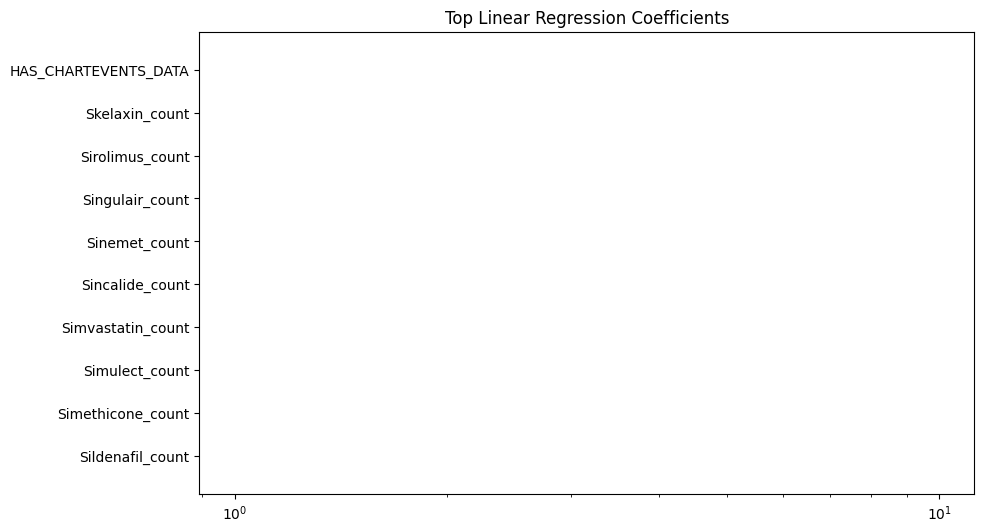

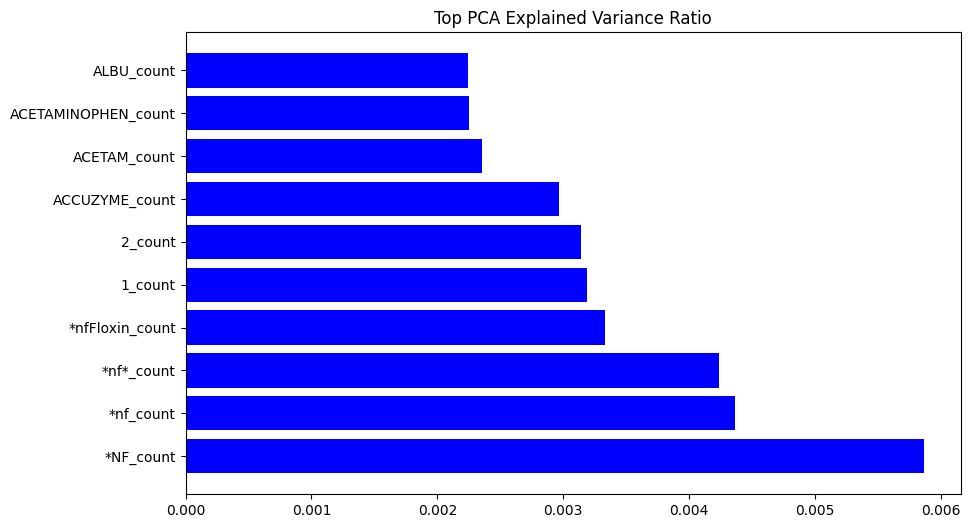

In [28]:
# Filters for numeric features
processed_df = processed_df[[i for i in numeric_features if i in processed_df.columns] + ['mortality_label']]

processed_df = processed_df.loc[:, ~processed_df.columns.duplicated()]
cols = list(processed_df.columns)
for i in range(len(cols)):
    cols[i] = "".join([i for i in cols[i] if i not in ['[', ']', ',', '>', '<']]).replace(" ", '_')
processed_df.columns = cols
processed_df = processed_df.dropna(axis = 1, how = 'any')
processed_df.drop(columns = ['SUBJECT_ID'], inplace = True)

    
# Now, processed_df is ready for further analysis or modeling
# Example call to your `analyze_features` function with processed data
# Assuming `analyze_features` is defined elsewhere and takes the scaled features, feature names, mortality labels, and other parameters.
unlabelled_df = processed_df.drop('mortality_label', axis=1)
analyze_features(features_scaled=unlabelled_df, 
                 feature_names=unlabelled_df.columns,
                 y=processed_df['mortality_label'], 
                 top_n_features=10, 
                 return_top_features=False)

In [26]:
# Function for equalizing data
def equalize_data(data, labels):
    data["Death"] = labels
    data = data.sample(frac = 1) 
    true_data = data[data["Death"] == 1]
    false_data = data[data["Death"] == 0]
    true_length, false_length = len(true_data), len(false_data)
    
    # Equalizes labels
    if true_length > false_length:
        sample_fraction = false_length / true_length
        true_data = true_data.sample(frac = sample_fraction)
    else:
        sample_fraction = true_length / false_length
        false_data = false_data.sample(frac = sample_fraction)
        
    # Recombines data
    data = pd.concat((true_data, false_data), axis = 0)
    labels = list(data['Death'])
    features = data.drop(columns = ['Death'])
    return features, labels


def feature_analysis(features, labels, top_features = None):
    # Analyzes feature importance via a variety of methods and filters features if enabled
    if top_features:
        feature_names = analyze_features(features_scaled = features.to_numpy(), feature_names = list(features.columns), y = labels,
                                    return_top_features = True, top_n_features = top_features,)
        return feature_names
    else:
        analyze_features(features_scaled = features.to_numpy(), feature_names = list(features.columns), y = labels, return_top_features = False)
    
# Tests all models on the aggregated features and data
def test_models(features, # Feature df = HAVE IT FILTERED  
                labels, # Mortality labels
                feature_names = None, # Feature names 
                equalize = True,
                rescale = True): # Equalize labels  

    # Initializes scaler
    scaler = StandardScaler()
    if feature_names != None:
        features = features[feature_names]
        
    print(f'Number of features: {len(features.columns)}')
    
    def k_fold_validation_for_sklearn(clf, features, labels, name='Random Forest'):
        print(f'Starting analysis for {name}')
        aucs = []
        mccs = []  # List to store MCC scores
        mean_fpr = np.linspace(0, 1, 100)
    
        for i, (train_index, test_index) in tqdm.tqdm(enumerate(kf.split(features)), total=n_splits):
            
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # Scale features if required
            if rescale == True:
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
            
            # Fit and predict
            clf.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)[:, 1]
            y_pred = clf.predict(X_test)  # Predictions for MCC
    
            # Compute ROC curve and AUC for this fold
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = skauc(fpr, tpr)
            aucs.append(roc_auc)
            
            # Compute MCC for this fold
            mcc = matthews_corrcoef(y_test, y_pred)
            mccs.append(mcc)
    
            # Interpolate all ROC curves at this points
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            plt.plot(mean_fpr, interp_tpr, alpha=0.4, label=f'Split {i + 1} AUC = {round(roc_auc, 3)}')
    
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    
        # Calculate the mean AUC, std deviation, mean MCC
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        mean_mcc = np.mean(mccs)  # Calculate mean MCC
        print(f'Mean AUC: {mean_auc:.3f} ± {std_auc:.3f}')
        print(f'Mean MCC: {mean_mcc:.3f}')
        plt.title(f'{name}, ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
        plt.legend(loc="lower right")
        plt.show()
    
        return clf

    print(features['mortality_label'])
    
    # Equalizes labels if enabled
    if equalize == True:
        features, labels = equalize_data(features, labels) 
    
    print(f'Number of processed data samples: {len(labels)}')
    
    # Prepare the data
    features_array, labels = features.to_numpy(), np.array(labels)
    
    # Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf_clf = k_fold_validation_for_sklearn(rf_clf, features_array, labels)
    
    # XGBoost Classifier
    xgb_clf = XGBClassifier(n_estimators=1000, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss',
                           name = 'XGBoost')
    xgb_clf = k_fold_validation_for_sklearn(xgb_clf, features_array, labels, name = 'XGBoost')
    
    # Custom-built network
    class NeuralNet(plit.LightningModule):
        def __init__(self, input_size, hidden_size=32):
            super(NeuralNet, self).__init__()
            
            self.network = nn.Sequential(
                nn.Linear(input_size, hidden_size * 8), nn.ReLU(),
                nn.BatchNorm1d(hidden_size * 8), nn.Dropout(0.3),
                
                nn.Linear(hidden_size * 8, hidden_size * 4), nn.ReLU(),
                nn.BatchNorm1d(hidden_size * 4), nn.Dropout(0.3),
                
                nn.Linear(hidden_size * 4, hidden_size * 2), nn.ReLU(),
                nn.BatchNorm1d(hidden_size * 2), nn.Dropout(0.3),
                
                nn.Linear(hidden_size * 2, hidden_size), nn.ReLU(),
                
                nn.Linear(hidden_size, hidden_size), nn.ReLU(),
                nn.BatchNorm1d(hidden_size), nn.Dropout(0.5),
            )

            self.final_linear = nn.Linear(hidden_size, 1)
            self.sigmoid = nn.Sigmoid()
            self.residual_transform = nn.Linear(input_size, hidden_size)
            
            # L1 and L2 regularization are defined but not used as layers
            
        def forward(self, x):
            out = self.network(x)  # Pass input through the network layers
            residual = self.residual_transform(x)  # Apply residual transformation to the original input
            out += residual  # Add residual connection
            out = self.final_linear(out)
            out = self.sigmoid(out)
            return out.squeeze()

        def training_step(self, batch, batch_idx):
            inputs, labels = batch
            outputs = self(inputs)
            loss = nn.BCELoss()(outputs, labels.view(-1))  # BCELoss for binary classification

            # Apply L1 and L2 regularization
            l1_reg = torch.tensor(0.)
            l2_reg = torch.tensor(0.)
            for param in self.parameters():
                l1_reg = l1_reg + torch.norm(param, 1)
                l2_reg = l2_reg + torch.norm(param, 2)

            # Regularization strengths need to be defined; for example:
            lambda1, lambda2 = 0.005, 0.005
            loss += lambda1 * l1_reg + lambda2 * l2_reg
            self.log("train_loss", loss)
            return loss

        def configure_optimizers(self):
            optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
            return optimizer
    
    def k_fold_validation_for_pytorch(model_class, features, labels, input_size):
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.figure()
        for train_index, test_index in tqdm.tqdm(kf.split(features), total = n_splits,):
            # Prepare data
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
           
            # Convert to tensors
            X_train_tensor, y_train_tensor = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
            X_test_tensor, y_test_tensor = torch.FloatTensor(X_test), torch.FloatTensor(y_test)
            
            # DataLoader setup
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            
            # Model setup
            model = model_class(input_size=input_size)
            trainer = plit.Trainer(max_epochs=20)
        
            trainer.fit(model, train_loader)
            
            # Evaluate
            model.eval()
            with torch.no_grad():
                y_prob = model(X_test_tensor).numpy()
            
            # Compute ROC curve and AUC for this fold
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = skauc(fpr, tpr)
            aucs.append(roc_auc)
            
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            plt.plot(mean_fpr, interp_tpr, alpha=0.4)
        
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        plt.title(f'Custom Neural Network Mean ROC (AUC = {mean_auc:.3f} $\pm$ {std_auc:.3f})')
        plt.legend(loc="lower right")
        plt.show()

    return rf_clf, xgb_clf, scaler
    #print("Custom Neural Network")
    #k_fold_validation_for_pytorch(NeuralNet, features_array, labels, input_size=features.shape[1])


In [27]:
# Tests models
test_models(unlabelled_df, 
                processed_df['mortality_label'], # Mortality labels
                feature_names = None, # Feature names 
                equalize = True,
                rescale = True) # Equalize labels  

Number of features: 9056
Number of processed data samples: 0
Starting analysis for Random Forest


NameError: name 'kf' is not defined